In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

!rm *.zip *.csv
!kaggle datasets download -d ronakbadhe/chess-evaluations
!unzip chess-evaluations.zip


rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.csv': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations
License(s): other
100% 199M/200M [00:03<00:00, 69.5MB/s]
100% 200M/200M [00:03<00:00, 53.5MB/s]
Archive:  chess-evaluations.zip
  inflating: chessData.csv           
  inflating: random_evals.csv        
  inflating: tactic_evals.csv        


# Introduction
Chess is a popular game that uses strategic thinking and tactical prowess, played for centuries and still counting. This dataset that we will be using comprises approximately 16 million unique chess positions, each evaluated by the Stockfish chess engine at a depth of 22. Stockfish, a state-of-the-art chess analysis tool, provides precise and detailed evaluations of positions, making this dataset highly valuable for research in artificial intelligence, game theory, and machine learning. The extensive depth of 22 ensures a deep and thorough analysis of each position, offering insights into optimal moves and strategies. This dataset can be instrumental in training advanced machine learning models, developing new chess algorithms, and conducting comprehensive studies on chess strategy and position evaluation.

In [ ]:
chessData_df = pd.read_csv('chessData.csv')
chessData_df

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...,+6
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...,+84
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...,0
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...,+115


In [89]:
arr = np.array(chessData_df['Evaluation'])
counter = 0
mates = 0
for i in arr:
  if i[0] != '#':
    val = int(i)
    if val < 3900 and val > -3900:
      counter += 1
    continue
  mates += 1
counter/(len(arr) - mates)

0.985256128248689

## Features to Add
### Unofficial list
- Material Advantage/Disadvantage
- Development of Pieces
- ~~Close to Pawn Promotion (?)~~ (Implied by Development of Pieces)
- ~~Castle Ability~~ (Already provided by FEN string)
- ~~Pawn Structure (?)~~ (Difficult and computationally expensive to evaluate)

# Data Exploration
### Since our dataset's only independent variable does not work well as either a continuous value or categorical variable, we will be extracting information from it.

The two main features we will be extracting from the chess position are **material advantage** (continuous value) and **development of the pieces** (can be scored into a continuous value). These two attributes will be the data we will use for our modeling as the independent variable to predict the Evaluation Score that has been provided by Stockfish.

---
Material Advantage is in the range of [-39, 39] and can be normalized into a smaller scale, such [-1, 1] or [0, 1].
\
Development of pieces will be scored using our own evaluation function (the criteria for scoring can be read below) and weighted on a 0-100 scale (where positive is white and negative is black like material advantage). This also can be normalized to a [-1,1] scale.
\
The Evaluation score by Stockfish is a bit tricky. Firstly, it is measured in centipawns, so 100 = 1 pawn. Secondly, due to the version of Stockfish that was used to collect this data, which is 11 compared to the present time at 16, we may see abnormally large evaluation scores (greater than 3900) which would greatly affect the scale and putting the distribution at a very difficult to predict area and there may be large discrepancies between our evaluation of development and this Stockfish evaluation. Lastly, the Evaluation data includes forced mate notation, which provides a number moves necessary to achieve checkmate rather than a number to evaluate the position.

# Data Preprocessing
For our 'material advantage' and 'development of pieces' features, we will normalize our values to [-1, 1] for both attributes as it should save on computational resources since we will be computing with smaller numbers while preserving the scale. As for the Evaluation values, due to the incredible discrepancy and gaps in values, we believe that limiting the values to $\pm300$ and having any forced checkmates be equal to those max/min values. Given that an evaluation of (the absolute value of) anything greater than 3900 would imply a similar advantage of the maximum material advantage, we believe there would be no significant impact if we were to equate any forced checkmate evaluation to be the same as a 300 point evaluation.

# Development of Pieces
#### The following function will check how well "developed" a player's core pieces are. There are many factors<sup>[[^1]]</sup> to this attribute, so our evaluation would certainly not be the most accurate. We also have our own arbitrary weights for evaluating as we cannot be completely sure how much "better developed" a piece is in relation to other types of pieces. The criteria that we will keep in mind for our evaluation function are the following.
- Queen
  - Penalty for early game development (first 5 moves) (0%, 5% if early game)
  - **Queen mobility** (15%, 20% if not early game)
- Pawn
  - ~~Pawn structure~~ (Difficult and computationally expensive to evaluate)
  - **Pawn Center** (10%, 5% if late game)
  - Penalty for "d" and "e" pawns being blocked at their starting squares, but no penalty if other pawns can go to the center instead (10%, 5% if late game)
  - Late game (25+ moves): Penalty for pawns that are still near start position (0%, 10% if late game)
- Knight
  - **Knight mobility** (15%)
  - Penalty if undefended (15%)
  - No weight if at start position
- Bishop
  - **Bishop mobility** (15%)
  - Bishop pair is considered marginally stronger than Bishop Knight and Knight Knight (5%)
  - ~~Color Weakness (missing a bishop and poor pawn structure)~~ (See Pawn)
  - Penalty if undefended (10%)
  - Quarter weight if at start position

> **Mobility omits squares controlled by enemy pawns**


[^1]: https://www.chessprogramming.org/Evaluation_of_Pieces

# Mobility Mapping
### The code below is used to map the mobility of the pieces with the exception of the king.
##### Hide this for your eyes' safety (Incredibly Ugly Code)

In [ ]:
# Mobility board to visualize where pieces can go and defend.
def mobility_board(board):
  all_squares = []
  for i in range(8):
    for j in range(8):
      all_squares.append(f'{chr(i + 97)}{j + 1}')

  def update(possible_moves, piece, board, color):
    for move in possible_moves:
      coord = Board.pos(move, board)
      if coord == None:
        continue
      occ = coord['Occupied']
      if occ == '':
        coord['Move/Capture'].append(piece)
      elif occ.islower():
        if color == 'b':
          coord['Defend'].append(piece)
        else:
          coord['Move/Capture'].append(piece)
      else:
        if color == 'b':
          coord['Move/Capture'].append(piece)
        else:
          coord['Defend'].append(piece)

  def knight(pos, color):
    piece = 'n' if color == 'b' else 'N'
    col = pos[0]
    row = pos[1]
    possible_moves = [f'{chr(ord(col) + 1)}{str(int(row) + 2)}', f'{chr(ord(col) + 1)}{str(int(row) - 2)}', \
                      f'{chr(ord(col) - 1)}{str(int(row) + 2)}', f'{chr(ord(col) - 1)}{str(int(row) - 2)}', \
                      f'{chr(ord(col) + 2)}{str(int(row) + 1)}', f'{chr(ord(col) + 2)}{str(int(row) - 1)}', \
                      f'{chr(ord(col) - 2)}{str(int(row) + 1)}', f'{chr(ord(col) - 2)}{str(int(row) - 1)}']

    update(possible_moves, piece, board, color)

  def bishop(pos, color):
    piece = 'b' if color == 'b' else 'B'
    col = pos[0]
    row = pos[1]
    possible_moves = []
    for i in range(1, 8):
      move = f'{chr(ord(col) + i)}{str(int(row) + i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) + i)}{str(int(row) - i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) - i)}{str(int(row) + i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) - i)}{str(int(row) - i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)

    update(possible_moves, piece, board, color)

  def rook(pos, color):
    piece = 'r' if color == 'b' else 'R'
    col = pos[0]
    row = pos[1]
    possible_moves = []
    for i in range(1, 8):
      move = f'{chr(ord(col) + i)}{str(int(row))}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) - i)}{str(int(row))}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col))}{str(int(row) + i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col))}{str(int(row) - i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)

    update(possible_moves, piece, board, color)

  def queen(pos, color):
    piece = 'q' if color == 'b' else 'Q'
    col = pos[0]
    row = pos[1]
    possible_moves = []
    ### Bishop ###
    for i in range(1, 8):
      move = f'{chr(ord(col) + i)}{str(int(row) + i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) + i)}{str(int(row) - i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) - i)}{str(int(row) + i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) - i)}{str(int(row) - i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)

    ### Rook ###
    for i in range(1, 8):
      move = f'{chr(ord(col) + i)}{str(int(row))}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col) - i)}{str(int(row))}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col))}{str(int(row) + i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)
    for i in range(1, 8):
      move = f'{chr(ord(col))}{str(int(row) - i)}'
      coord = Board.pos(move, board)
      if coord == None or coord['Occupied'] != '':
        possible_moves.append(move)
        break
      possible_moves.append(move)

    update(possible_moves, piece, board, color)

  def pawn(pos, color):
    piece = 'p' if color == 'b' else 'P'
    col = pos[0]
    row = pos[1]
    if color == 'b':
      ### Move ###
      move1 = f'{chr(ord(col))}{str(int(row) - 1)}'
      coord = Board.pos(move1, board)
      if coord['Occupied'] == '':
        coord['Move/Capture'].append(piece)
        if row == '7':
          move2 = f'{chr(ord(col))}{str(int(row) - 2)}'
          coord = Board.pos(move2, board)
          if coord['Occupied'] == '':
            coord['Move/Capture'].append(piece)
      ### Capture/Defend ###
      move = [f'{chr(ord(col) - 1)}{str(int(row) - 1)}', f'{chr(ord(col) + 1)}{str(int(row) - 1)}']
      for m in move:
        coord = Board.pos(m, board)
        if coord == None:
          continue
        occu = coord['Occupied']
        if occu != '':
          if occu.islower():
            coord['Defend'].append(piece)
          else:
            coord['Move/Capture'].append(piece)
        else:
          coord['Pawn_Control'].append(piece)
    else:
      ### Move ###
      move1 = f'{chr(ord(col))}{str(int(row) + 1)}'
      coord = Board.pos(move1, board)
      if coord['Occupied'] == '':
        coord['Move/Capture'].append(piece)
        if row == '2':
          move2 = f'{chr(ord(col))}{str(int(row) + 2)}'
          coord = Board.pos(move2, board)
          if coord['Occupied'] == '':
            coord['Move/Capture'].append(piece)
      ### Capture/Defend ###
      move = [f'{chr(ord(col) - 1)}{str(int(row) + 1)}', f'{chr(ord(col) + 1)}{str(int(row) + 1)}']
      for m in move:
        coord = Board.pos(m, board)
        if coord == None:
          continue
        occu = coord['Occupied']
        if occu != '':
          if occu.islower():
            coord['Move/Capture'].append(piece)
          else:
            coord['Defend'].append(piece)
        else:
          coord['Pawn_Control'].append(piece)

  for square in all_squares:
    coord = Board.pos(square, board)
    piece = coord['Occupied']
    color = 'w' if piece.isupper() else 'b'
    if piece.lower() == 'p':
      pawn(square, color)
    elif piece.lower() == 'q':
      queen(square, color)
    elif piece.lower() == 'r':
      rook(square, color)
    elif piece.lower() == 'b':
      bishop(square, color)
    elif piece.lower() == 'n':
      knight(square, color)

  return board

# Functions for Features
##### Board Object contains the board representation of the FEN string, mobility map of all pieces except the King, and other minor information that can be extracted from the position.

In [76]:
# Convert FEN to an index-based board
def FEN_to_board(fen):
  fen_board = fen.split(' ')[0]
  mobility_board = [[{'Move/Capture': [], 'Defend': [], 'Pawn_Control': [], 'Occupied': ''} for i in range(8)] for j in range(8)]
  piece_placements = {'r': [], 'n': [], 'b': [], 'q': [], 'p': [], 'k': [], 'R': [], 'N': [], 'B': [], 'Q': [], 'P': [], 'K': []}
  mirror_board_center = {'1': '8', '2': '7', '3': '6', '4': '5', '5': '4', '6': '3', '7': '2', '8': '1'}
  row = 0
  idx = 0
  board = ['' for i in range(8)]
  nums = [str(i) for i in range(1, 9)]
  for c in fen_board:
    if c == '/':
      row += 1
      idx = 0
      continue
    elif c not in nums:
      board[row] += c
      mobility_board[row][idx]['Occupied'] = c
      piece_placements[c] += [chr(idx + 97) + mirror_board_center[str(row + 1)]]
    else:
      board[row] += '_' * int(c)
      idx += int(c)
      continue
    idx += 1
  return board, mobility_board, piece_placements

# Board object that will contain all data processing functions.
class Board:
  def __init__(self, fen):
    self.board, self.mobility, self.piece_placements = FEN_to_board(fen)
    self.board.reverse()
    self.mobility.reverse()
    self.mobility = mobility_board(self.mobility)
    self.fen = fen
    self.moves = int(fen.split(' ')[5])
    self.black_pieces = {'r': 5, 'n': 3, 'b': 3, 'q': 9, 'p': 1, 'k': 0}
    self.white_pieces = {p.upper() : v for p, v in self.black_pieces.items()}

  def __repr__(self):
    board_str = ''
    for row in reversed(range(len(self.board))):
      board_str += str(row + 1) + ' | '
      for c in self.board[row]:
        board_str += c + ' '
      board_str += '\n'
    board_str += '   ----------------\n    a b c d e f g h'
    return board_str

  def __str__(self):
    return self.fen

  # Use chess position terminology (i.e. e4, h8)
  @classmethod
  def pos(self, pos, board):
    if len(pos) != 2:
      #print('Not a valid chess position')
      return
    valid_letters = 'abcdefgh'
    valid_num = '12345678'
    col = pos[0].lower()
    row = pos[1]
    if col not in valid_letters or row not in valid_num:
      #print('Not a valid chess position')
      return
    col = ord(col) - 97
    row = int(row) - 1
    return board[row][col]

  # Calculate material advantage of the position (positive value for white, negative value for black)
  def advantage(self):
    white = 0
    black = 0
    for row in self.board:
      for p in row:
        if p == '_':
          continue
        elif p > 'Z':
          black += self.black_pieces[p]
        else:
          white += self.white_pieces[p]

    return white - black

  def evaluate(self):
    mobile = {**{piece : 0 for piece in self.black_pieces.keys()}, **{piece : 0 for piece in self.white_pieces.keys()}}
    scores = {'w' : 0, 'b' : 0}
    for row in self.mobility:
      for square in row:
        black_controlled = 'p' in square['Pawn_Control']
        white_controlled = 'P' in square['Pawn_Control']
        for piece in square['Move/Capture']:
          if (piece.isupper() and not black_controlled) or (piece.islower() and not white_controlled):
            mobile[piece] += 1
        for piece in square['Defend']:
          mobile[piece] += 1
    def queen(color):
      piece = 'Q' if color == 'w' else 'q'
      weight = 20
      if self.moves <= 5:
        weight = 15
        start = 'd1' if color == 'w' else 'd8'
        if Board.pos(start, self.board) == piece:
          scores[color] += 5
      scores[color] += (mobile[piece] / 20) * weight

    def pawn(color):
      piece = 'p' if color == 'b' else 'P'
      center = 'd4/e4' if color == 'w' else 'd5/e5'
      end_weight = 2 if self.moves >= 25 else 1
      # Center Pawns
      for pos in center.split('/'):
        square = Board.pos(pos, self.mobility)
        if square['Occupied'] == piece:
          scores[color] += 10 / end_weight
          break
      # Immobile Starter Center Pawns
      start_center = 'd3/d4/e3/e4' if color == 'w' else 'd5/d6/e5/e6'
      for pos in start_center.split('/'):
        square = Board.pos(pos, self.mobility)
        if piece in square['Move/Capture'] or piece == square['Occupied']:
          scores[color] += 2.5 / end_weight
      # Late Game Pawns
      if self.moves >= 25:
        rows = '2/3' if color == 'w' else '6/7'
        for pos in [chr(val) for val in range(97, 105) for r in rows.split('/')]:
          if Board.pos(pos, self.board) != piece:
            scores[color] += (10 / 16)

    def knight(color):
      piece = 'n' if color == 'b' else 'N'
      score = 0
      score += (mobile[piece] / 8) * 15
      positions = self.piece_placements[piece]
      for pos in positions:
        if len(Board.pos(pos, self.mobility)['Defend']) > 0:
          score += 15 / len(positions)
      # Penalize being at start
      count_dev = 2
      start = '1' if color == 'w' else '8'
      for place in self.piece_placements[piece]:
        if place[1] == start:
          count_dev -= 1
      score *= 0.5 * max(count_dev, 0)
      scores[color] += score


    def bishop(color):
      piece = 'b' if color == 'b' else 'B'
      score = 0
      score += (mobile[piece] / 8) * 15
      positions = self.piece_placements[piece]
      for pos in positions:
        if len(Board.pos(pos, self.mobility)['Defend']) > 0:
          score += 15 / len(positions)
      if len(positions) >= 2:
        score += 5

      # Penalize being at start
      count_undev = 0
      start = '1' if color == 'w' else '8'
      for place in self.piece_placements[piece]:
        if place[1] == start:
          count_undev += 1
      weights = [1, 0.5, 0.25]
      score *= weights[min(count_undev, 2)]
      scores[color] += score

    for color in scores.keys():
      pawn(color)
      knight(color)
      queen(color)
      bishop(color)

    return scores['w'] - scores['b']

board = Board(chessData_df['FEN'][0])
print(board.evaluate())

11.15625


# TESTING PURPOSES

In [129]:
test = chessData_df.head()
fen_strs = np.array(test['FEN'])
boards = pd.DataFrame(np.array([Board(fen) for fen in fen_strs]), columns=['FEN'])
test = test.drop('FEN', axis=1)
test = pd.concat([test, boards], axis=1)

In [130]:
advantages = np.array([board.advantage() for board in boards['FEN']])
advantages

array([0, 0, 0, 0, 0])

In [131]:
evals = np.array([board.evaluate() for board in boards['FEN']])

In [132]:
evaluations = np.array(test['Evaluation'])
for i in range(len(evaluations)):
  eval = evaluations[i]
  if '#' in eval:
    evaluations[i] = eval[1] + '3900'
  evaluations[i] = int(evaluations[i])
evaluations = pd.DataFrame(evaluations, columns=['Evaluation'])
test = test.drop('Evaluation', axis=1)
test = pd.concat([test, evaluations], axis=1)

In [133]:
# chessData_df = chessData_df.assign(material_advantage=advantages)
# chessData_df
test = test.assign(Material_Advantage=advantages)
test = test.assign(Development=evals)
test

,FEN,Evaluation,Material_Advantage,Development
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10,0,11.15625
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,56,0,7.50000
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9,0,8.37500
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,52,0,-1.56250
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26,0,12.40625


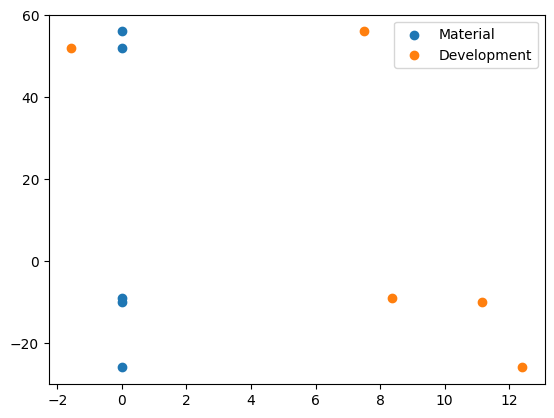

In [140]:
eval = test['Evaluation']
develop = test['Development']
adv = test['Material_Advantage']
plt.scatter(adv, eval, label='Material')
plt.scatter(develop, eval, label='Development')
plt.legend()

# Full Data Plot

In [ ]:
fen_strs = np.array(chessData_df['FEN'])
boards = pd.DataFrame(np.array([Board(fen) for fen in fen_strs]), columns=['FEN'])
chessData_df = chessData_df.drop('FEN', axis=1)
chessData_df = pd.concat([chessData_df, boards], axis=1)
advantages = np.array([board.advantage() for board in boards['FEN']])

evals = np.array([board.evaluate() for board in boards['FEN']])
evaluations = np.array(chessData_df['Evaluation'])
for i in range(len(evaluations)):
  eval = evaluations[i]
  if '#' in eval:
    evaluations[i] = eval[1] + '3900'
  evaluations[i] = int(evaluations[i])

evaluations = pd.DataFrame(evaluations, columns=['Evaluation'])
chessData_df = chessData_df.drop('Evaluation', axis=1)
chessData_df = pd.concat([chessData_df, evaluations], axis=1)
chessData_df = chessData_df.assign(Material_Advantage=advantages)
chessData_df = chessData_df.assign(Development=evals)

eval = chessData_df['Evaluation']
develop = chessData_df['Development']
adv = chessData_df['Material_Advantage']
plt.scatter(adv, eval, label='Material')
plt.scatter(develop, eval, label='Development')
plt.legend()